<div align='center'>

# Convolutional Neural Network (CNN)
    
</div>

## 1. Import Neccessary Pakages

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity, he_normal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input

print(tf.__version__)

2.19.0


## 2. Download and prepare the CIFAR10 dataset

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
# Choose medium (128) batch size to balance between speed and efficiency
batch_size = 128

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Original batch shape: (9, 32, 32, 3)
Labels shape: (9, 1)


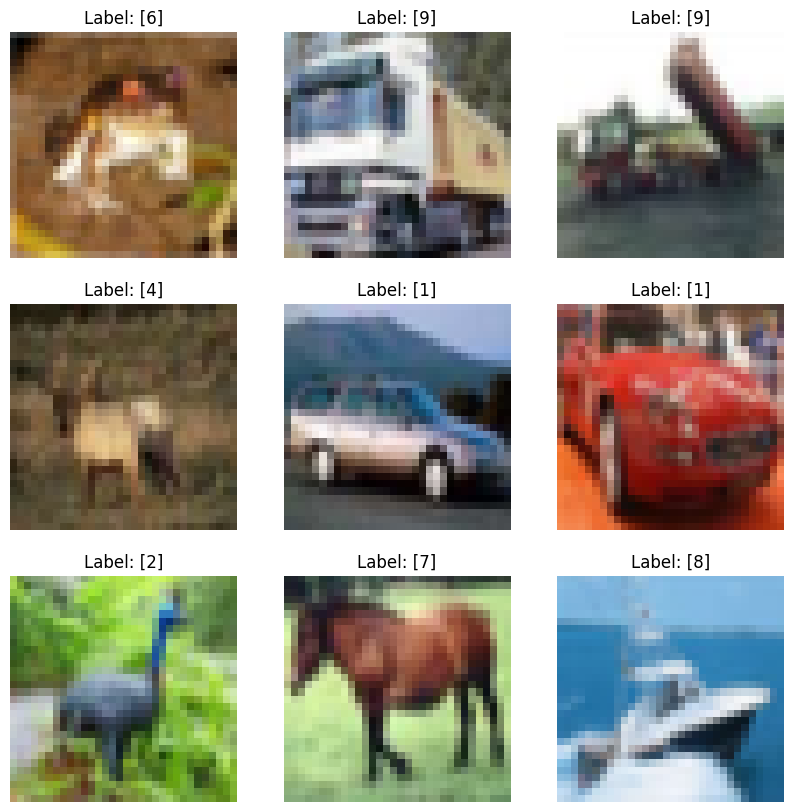

In [4]:
# Visualize the original images
raw_train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(9)

for images, labels in raw_train_dataset.take(1):
    print("Original batch shape:", images.shape)
    print("Labels shape:", labels.shape)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # original format
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

## 3. Data Preprocessing

### 3.1 - Rescaling

In [5]:
# Create resizing and rescaling using tensorflow
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

### 3.2 - Data Augmentation

In [6]:
# Create a data augmentation layer
data_augmentation = Sequential(
    [
        Input(shape=(32, 32, 3)),
        RandomFlip("horizontal"),
        RandomRotation(0.05),
        RandomZoom(0.05),
    ]
)

### 3.3 - Create train_dataset and test_dataset

In [7]:
# Using df.data.AUTOTUNE for faster training time and efficiency
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
# Create train and test datasets, creating a simple preprocessing pipeline
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .cache()
    .shuffle(10000)
    .map(lambda x, y: (rescale(x), y))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


# Test dataset
test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    .cache()
    .map(lambda x, y: (rescale(x), y))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

## 5. Create the convolutional base

As the architecture of a CNN model, the height, width will reduce overtime, while the number of channels will increase. Moreover, I stack 2 **Conv2D** layers to help the model to learn more features. This is just a simple model, so the accuracy after training might not very high.

Because this is just a simple model, so I will use the Sequential API.

In [9]:
# Create a simple CNN model
model = models.Sequential( # Using Sequential API for simplicity
    [
        data_augmentation, # Add data augmentation layer
        Conv2D(32, (3, 3), padding='same', activation='relu'), # padding same to keep the height and width the same
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'), # padding same to keep the height and width the same
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Reduce the height and width by half

        Conv2D(64, (3, 3), padding='same', activation='relu'), # (16, 16, 64)
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'), # (16, 16, 64)
        BatchNormalization(),
        MaxPooling2D((2, 2)), # (8, 8, 64)

        Conv2D(128, (3, 3), padding='same', activation='relu'), # (8, 8, 128)
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),  # (8, 8, 128)
        BatchNormalization(),
        MaxPooling2D((2, 2)), # (4, 4, 128)
        Dropout(0.3), # Dropout layer for regularizations

        # Conv2D(256, (3, 3), padding='same', activation='relu'), # (4, 4, 256)
        # BatchNormalization(),
        # Conv2D(256, (3, 3), padding='same', activation='relu'), # (4, 4, 256)
        # BatchNormalization(),
        # MaxPooling2D((2, 2)), # (2, 2, 256)
        # Dropout(0.3),

        # Conv2D(512, (3, 3), padding='same', activation='relu'),
        # BatchNormalization(),
        # Conv2D(512, (3, 3), padding='same', activation='relu'),
        # BatchNormalization(),
        # Dropout(0.3)
    ]
)

In [10]:
# Check for the summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 128)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,800 (1.10 MB)

 Trainable params: 287,904 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

## 5. Add Dense layers on top

In [11]:
# Add Dense layers after flatten, with the final dense layers to give 10 outputs (10 classes)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))

In [12]:
# Check the model summary one more time, this is the complete architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 847,530 (3.23 MB)

 Trainable params: 846,634 (3.23 MB)

 Non-trainable params: 896 (3.50 KB)

## 6. Compile and train the model

In [13]:
# Early stopping to optimize training time and reduce overfitting
early_stop = EarlyStopping(
    monitor="val_loss",   # Stop if validation loss stops improving
    patience=15,          # Allow some patience
    restore_best_weights=True,  # Roll back to the best model
    verbose=1
)

Using ReduceLROnPlateau for learning rate decay, this will reduce the learning rate when the validation loss shows no improvements after a specific number of epochs.

In [14]:
# Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Watch validation loss
    factor=0.5,           # Reduce LR by half
    patience=5,           # Wait 5 epochs before reducing
    min_lr=1e-6,          # Don’t let LR go below this
    verbose=1
)

In [15]:
# Optimizer Adam
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=test_dataset,
    callbacks=[early_stop, reduce_lr], # Includ early_stop and reduce_lr
    verbose=1
)

Epoch 1/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4105 - loss: 1.6939 - val_accuracy: 0.3207 - val_loss: 2.1874 - learning_rate: 0.0010
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6146 - loss: 1.0786 - val_accuracy: 0.6870 - val_loss: 0.9120 - learning_rate: 0.0010
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6895 - loss: 0.8813 - val_accuracy: 0.6830 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7301 - loss: 0.7632 - val_accuracy: 0.7369 - val_loss: 0.7775 - learning_rate: 0.0010
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7621 - loss: 0.6780 - val_accuracy: 0.7175 - val_loss: 0.8523 - learning_rate: 0.0010
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7830 - loss: 0.6249 - val_accuracy: 0.7467 - val_loss: 0.7401 - learning_rate: 0.0010
Epoch 7/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7972 - 

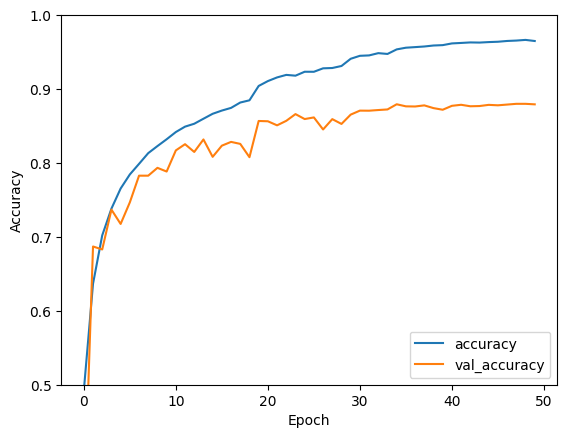

In [16]:
# Plot the learning curve
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## 7. Evaluate the model

In [17]:
# Calculate the test loss and accuracy
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

# Print the test accuracy
print(test_acc)

79/79 - 0s - 4ms/step - accuracy: 0.8794 - loss: 0.4346
0.8794000148773193


<div align='center'>

## RESIDUAL NETWORK
    
</div>

The second section of this lab will focus on buiding a **Residual Network** using TensorFlow to improve the accuracy on the CIFAR 10 dataset.

<div style="text-align: center;">
  <img src="https://www.researchgate.net/profile/Md-Rahat-Rabbani/publication/329882891/figure/fig1/AS:700195995770880@1546331454933/Residual-neural-network-A-Network-architecture-B-Identity-block-each-identity.png"
       alt="Residual Network Architecture"
       style="max-width: 80%; height: auto;">
</div>


The image above shows the general architecture of a `Residual Network` with four main components:

* Identity block - keeping the height and width of the input to be the same, while increasing the number of channels. This block is used for the model to capture the features of the data.

* Convolutional block - changes the height and width of the feature maps (usually reduces by stride > 1) and increases the number of channels. This block is used to downsample the input, making the feature maps richer.

* Pooling layer - reduces the spatial dimensions (height and width) while keeping the depth (channels).

* Dense layer - maps extracted features into final outputs.

`Residual Network` handles multiple inputs because it adds the shortcut at the end, so I will use Functional API to build a it instead of Sequential API.

Functional API allows me to deeply control the inputs of the layers.

## 8. Identity Block

In [18]:
def identity_block(X, f, filters, initializer=he_normal):
    """
    Implementation of identity block

    Arguments
    X --- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f --- integer, specifying the shape of the middle CONV's window for the main path
    filters --- python list of integers, defining the number of filters in the
        CONV layers of the main path
    initializer --- to set yp the initial weights of a layer. Equals to random
        uniform initializer

    Returns:
    X --- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Get the filters
    F1, F2 = filters

    # Save the input value. For residual
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size = 1, strides=(1,1), padding='valid', kernel_initializer=initializer(seed=42),
              kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1,1), padding='same',kernel_initializer=initializer(seed=42),
              kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: add shortcut to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

## 9. Convolutional Block

In [19]:
def convolutional_block(X, f, filters, s=2, initializer=he_normal):
    """
    Convolutional block with stride s
    """
    F1, F2 = filters
    X_shortcut = X

    # Main path
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid',
               kernel_initializer=initializer(seed=42),
               kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Main Path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same',
               kernel_initializer=initializer(seed=42),
               kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(F2, (1, 1), strides=(s, s), padding='valid',
                        kernel_initializer=initializer(seed=42),
                        kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## 10. Build a ResNet model

Create a ResNet function, which combines the two identity and convolutional blocks with MaxPooling and Dense layers.

In [20]:
# Create a ResNet model, which takes the input shaped (32, 32, 3) and ouput 10 class scores
def ResNet(input_shape=(32, 32, 3), classes=10):

    X_input = Input(input_shape) # Define the input shape

    X = data_augmentation(X_input) # Perform data Augmentation

    # Stage 1 - First Conv2D to capture some input features
    X = Conv2D(64, (3, 3), strides=(1, 1),
               padding='same', kernel_initializer=he_normal(seed=42),
               kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)


    # Stage 2 - Stack 1 convolutional block with 2 identity blocks
    X = convolutional_block(X, f=3, filters=[64, 64], s=1)
    X = identity_block(X, 3, [64, 64])
    X = identity_block(X, 3, [64, 64])

    # Stage 3 - Stack 1 convolutional block with 2 identity blocks
    X = convolutional_block(X, f=3, filters=[128, 128], s=2)
    X = identity_block(X, 3, [128, 128])
    X = identity_block(X, 3, [128, 128])

    # Stage 4 - Stack 1 convolutional block with 2 identity blocks
    X = convolutional_block(X, f=3, filters=[256, 256], s=2)
    X = identity_block(X, 3, [256, 256])
    X = identity_block(X, 3, [256, 256])

    # Stage 5 - Stack 1 convolutional block with 2 identity blocks
    X = convolutional_block(X, f=3, filters=[512, 512], s=2)
    X = identity_block(X, 3, [512, 512])
    X = identity_block(X, 3, [512, 512])

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Add Dropout for regularizations
    X = Dropout(0.3)(X)

    # Output
    X = Dense(classes, activation='softmax',
              kernel_initializer=he_normal(seed=42), kernel_regularizer=tf.keras.regularizers.l2(5e-4))(X)

    model = Model(inputs=X_input, outputs=X)
    return model

## 11. 1st ResNet model

Build a first ResNet model with CosineDecayRestarts, which is a learning rate decay with restart schedule. The learning rate will reduce to the predefined minimum number before increasing again. This might help the model to escape from the Plateau or local minima.

In [21]:
CDR_model = ResNet(input_shape=(32, 32, 3), classes=10)

# Cosine decay restarts learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.1,
    first_decay_steps=200,
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-5
)

# Check for the summary of the model
CDR_model.summary()

# Optimizer with the learning rate schedule
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
CDR_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# Create checkpoint
checkpoint = ModelCheckpoint(
    "best_resnet_CDR.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# === Training ===
CDR_history = CDR_model.fit(
    train_dataset,
    epochs=200,
    validation_data=test_dataset,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,792 │ sequential_1[5][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      4,160 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      4,160 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │      4,160 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 10,489,674 (40.01 MB)

 Trainable params: 10,476,106 (39.96 MB)

 Non-trainable params: 13,568 (53.00 KB)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1637 - loss: 10.8819
Epoch 1: val_accuracy improved from -inf to 0.25620, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.1638 - loss: 10.8774 - val_accuracy: 0.2562 - val_loss: 7.3368
Epoch 2/200
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3669 - loss: 6.8062
Epoch 2: val_accuracy improved from 0.25620 to 0.31540, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3669 - loss: 6.8046 - val_accuracy: 0.3154 - val_loss: 5.9497
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4454 - loss: 5.2278
Epoch 3: val_accuracy improved from 0.31540 to 0.49600, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.4455 - loss: 5.2270 - val_accuracy: 0.4960 - val_loss: 4.4639
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5176 - loss: 4.3610
Epoch 4: val_accuracy did not improve from 0.49600
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5176 - loss: 4.3608 - val_accuracy: 0.4343 - val_loss: 4.2627
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5205 - loss: 3.7335
Epoch 5: val_accuracy improved from 0.49600 to 0.50860, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5206 - loss: 3.7329 - val_accuracy: 0.5086 - val_loss: 3.2633
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5811 - loss: 2.9621
Epoch 6: val_accuracy improved from 0.50860 to 0.64070, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5812 - loss: 2.9618 - val_accuracy: 0.6407 - val_loss: 2.5742
Epoch 7/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6591 - loss: 2.4877
Epoch 7: val_accuracy improved from 0.64070 to 0.68730, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.6592 - loss: 2.4875 - val_accuracy: 0.6873 - val_loss: 2.3347
Epoch 8/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7045 - loss: 2.2712
Epoch 8: val_accuracy did not improve from 0.68730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7045 - loss: 2.2713 - val_accuracy: 0.5512 - val_loss: 2.6273
Epoch 9/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6465 - loss: 2.2695
Epoch 9: val_accuracy did not improve from 0.68730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6466 - loss: 2.2693 - val_accuracy: 0.6070 - val_loss: 2.2519
Epoch 10/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6913 - loss: 1.8996
Epoch 10: val_accuracy did not improve from 0.68730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6913 - loss: 1.8995 - val_accuracy: 0.6817 - val_loss: 1.8025
Epoch 11/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7318 - loss: 1.6182
Epoch 11: val_ac

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7676 - loss: 1.4065 - val_accuracy: 0.7561 - val_loss: 1.3933
Epoch 13/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8000 - loss: 1.2382
Epoch 13: val_accuracy improved from 0.75610 to 0.79500, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8000 - loss: 1.2382 - val_accuracy: 0.7950 - val_loss: 1.2305
Epoch 14/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8351 - loss: 1.0958
Epoch 14: val_accuracy did not improve from 0.79500
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8351 - loss: 1.0957 - val_accuracy: 0.7940 - val_loss: 1.2231
Epoch 15/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8677 - loss: 0.9790
Epoch 15: val_accuracy improved from 0.79500 to 0.82730, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8677 - loss: 0.9790 - val_accuracy: 0.8273 - val_loss: 1.0978
Epoch 16/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8867 - loss: 0.9189
Epoch 16: val_accuracy did not improve from 0.82730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8867 - loss: 0.9190 - val_accuracy: 0.5324 - val_loss: 2.5226
Epoch 17/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7685 - loss: 1.2437
Epoch 17: val_accuracy did not improve from 0.82730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7685 - loss: 1.2437 - val_accuracy: 0.7338 - val_loss: 1.3315
Epoch 18/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7912 - loss: 1.1457
Epoch 18: val_accuracy did not improve from 0.82730
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7912 - loss: 1.1457 - val_accuracy: 0.7720 - val_loss: 1.1933
Epoch 19/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8015 - loss: 1.0782
Epoch 19: va

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8947 - loss: 0.6762 - val_accuracy: 0.8417 - val_loss: 0.8367
Epoch 27/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9094 - loss: 0.6215
Epoch 27: val_accuracy improved from 0.84170 to 0.84780, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9094 - loss: 0.6214 - val_accuracy: 0.8478 - val_loss: 0.8307
Epoch 28/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9287 - loss: 0.5584
Epoch 28: val_accuracy improved from 0.84780 to 0.86140, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9287 - loss: 0.5584 - val_accuracy: 0.8614 - val_loss: 0.7898
Epoch 29/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9429 - loss: 0.5095
Epoch 29: val_accuracy improved from 0.86140 to 0.86920, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9429 - loss: 0.5094 - val_accuracy: 0.8692 - val_loss: 0.7491
Epoch 30/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9568 - loss: 0.4669
Epoch 30: val_accuracy improved from 0.86920 to 0.87310, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9568 - loss: 0.4669 - val_accuracy: 0.8731 - val_loss: 0.7419
Epoch 31/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9653 - loss: 0.4351
Epoch 31: val_accuracy improved from 0.87310 to 0.87910, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9653 - loss: 0.4351 - val_accuracy: 0.8791 - val_loss: 0.7328
Epoch 32/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9695 - loss: 0.4244
Epoch 32: val_accuracy improved from 0.87910 to 0.88030, saving model to best_resnet_CDR.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9695 - loss: 0.4244 - val_accuracy: 0.8803 - val_loss: 0.7304
Epoch 33/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9180 - loss: 0.5736
Epoch 33: val_accuracy did not improve from 0.88030
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9179 - loss: 0.5740 - val_accuracy: 0.7407 - val_loss: 1.2216
Epoch 34/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8481 - loss: 0.8185
Epoch 34: val_accuracy did not improve from 0.88030
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8481 - loss: 0.8185 - val_accuracy: 0.7646 - val_loss: 1.1344
Epoch 35/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8544 - loss: 0.8079
Epoch 35: val_accuracy did not improve from 0.88030
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8544 - loss: 0.8079 - val_accuracy: 0.8064 - val_loss: 0.9751
Epoch 36/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8621 - loss: 0.7982
Epoch 36: va

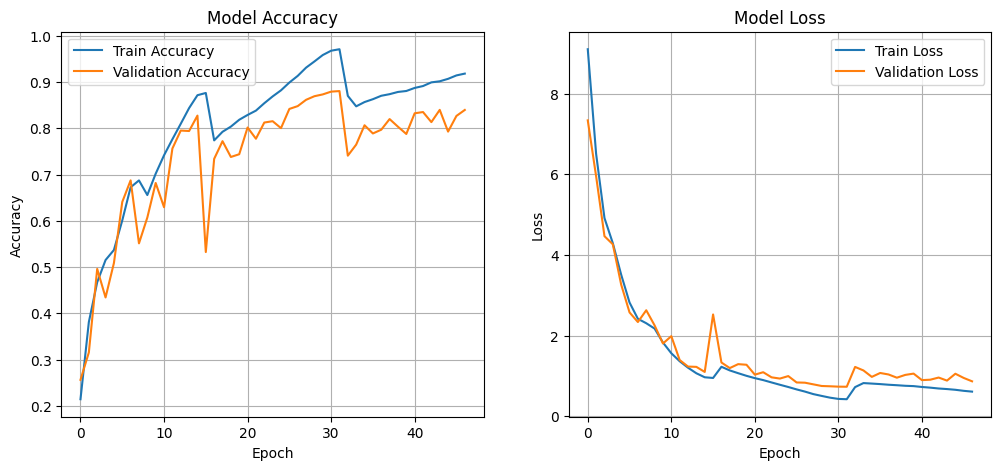

In [22]:
# Plot learning curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(CDR_history.history['accuracy'], label='Train Accuracy')
plt.plot(CDR_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(CDR_history.history['loss'], label='Train Loss')
plt.plot(CDR_history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


## 11. 2nd ResNet model

Build a first ResNet model with ReduceLROnPlateau.

In [23]:
RLOP_model = ResNet(input_shape=(32, 32, 3), classes=10)

# Check for the summary of the model
RLOP_model.summary()

# Optimizer SGD
opt = SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

# Loss function
loss = SparseCategoricalCrossentropy(from_logits=False)

# Compile model
RLOP_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# Creat check point
checkpoint = ModelCheckpoint(
    "best_resnet_RLOP.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# === Training ===
RLOP_history = RLOP_model.fit(
    train_dataset,
    epochs=200,
    validation_data=test_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32, 3) │          0 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │      1,792 │ sequential_1[6][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │      4,160 │ activation_25[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_26[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │      4,160 │ activation_25[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 32, 32,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │      4,160 │ activation_27[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 10,489,674 (40.01 MB)

 Trainable params: 10,476,106 (39.96 MB)

 Non-trainable params: 13,568 (53.00 KB)

Epoch 1/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1943 - loss: 12.0419
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.1945 - loss: 12.0359 - val_accuracy: 0.2500 - val_loss: 6.8958 - learning_rate: 0.1000
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4059 - loss: 5.7550
Epoch 2: val_accuracy improved from 0.25000 to 0.38600, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.4059 - loss: 5.7532 - val_accuracy: 0.3860 - val_loss: 3.9804 - learning_rate: 0.1000
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4837 - loss: 3.3956
Epoch 3: val_accuracy improved from 0.38600 to 0.45930, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.4837 - loss: 3.3948 - val_accuracy: 0.4593 - val_loss: 2.7274 - learning_rate: 0.1000
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5397 - loss: 2.3105
Epoch 4: val_accuracy improved from 0.45930 to 0.47840, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5397 - loss: 2.3101 - val_accuracy: 0.4784 - val_loss: 2.1169 - learning_rate: 0.1000
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6020 - loss: 1.7630
Epoch 5: val_accuracy improved from 0.47840 to 0.52880, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.6020 - loss: 1.7628 - val_accuracy: 0.5288 - val_loss: 1.8269 - learning_rate: 0.1000
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6407 - loss: 1.5016
Epoch 6: val_accuracy improved from 0.52880 to 0.60380, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.6407 - loss: 1.5015 - val_accuracy: 0.6038 - val_loss: 1.5496 - learning_rate: 0.1000
Epoch 7/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6685 - loss: 1.3671
Epoch 7: val_accuracy did not improve from 0.60380
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6685 - loss: 1.3670 - val_accuracy: 0.5464 - val_loss: 1.7210 - learning_rate: 0.1000
Epoch 8/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6999 - loss: 1.2757
Epoch 8: val_accuracy improved from 0.60380 to 0.62040, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.6999 - loss: 1.2756 - val_accuracy: 0.6204 - val_loss: 1.5997 - learning_rate: 0.1000
Epoch 9/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7195 - loss: 1.2218
Epoch 9: val_accuracy did not improve from 0.62040
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7195 - loss: 1.2218 - val_accuracy: 0.4166 - val_loss: 3.1443 - learning_rate: 0.1000
Epoch 10/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7314 - loss: 1.1936
Epoch 10: val_accuracy did not improve from 0.62040
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7315 - loss: 1.1936 - val_accuracy: 0.5841 - val_loss: 1.6600 - learning_rate: 0.1000
Epoch 11/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7433 - loss: 1.1702
Epoch 11: val_accuracy improved from 0.62040 to 0.69060, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7433 - loss: 1.1702 - val_accuracy: 0.6906 - val_loss: 1.3144 - learning_rate: 0.1000
Epoch 12/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7547 - loss: 1.1452
Epoch 12: val_accuracy improved from 0.69060 to 0.70310, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7547 - loss: 1.1452 - val_accuracy: 0.7031 - val_loss: 1.3198 - learning_rate: 0.1000
Epoch 13/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7652 - loss: 1.1381
Epoch 13: val_accuracy improved from 0.70310 to 0.71300, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7652 - loss: 1.1381 - val_accuracy: 0.7130 - val_loss: 1.2887 - learning_rate: 0.1000
Epoch 14/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7679 - loss: 1.1267
Epoch 14: val_accuracy did not improve from 0.71300
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7679 - loss: 1.1267 - val_accuracy: 0.5609 - val_loss: 1.8589 - learning_rate: 0.1000
Epoch 15/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7727 - loss: 1.1300
Epoch 15: val_accuracy did not improve from 0.71300
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7727 - loss: 1.1300 - val_accuracy: 0.6769 - val_loss: 1.4424 - learning_rate: 0.1000
Epoch 16/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7772 - loss: 1.1153
Epoch 16: val_accuracy did not improve from 0.71300
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.7772 - loss: 1.1153 - val_accuracy: 0.5871 - val_loss: 1.9416 - learning_rate: 0.1000
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8369 - loss: 0.8868 - val_accuracy: 0.7622 - val_loss: 1.0739 - learning_rate: 0.0500
Epoch 21/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8324 - loss: 0.8711
Epoch 21: val_accuracy improved from 0.76220 to 0.78750, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8324 - loss: 0.8711 - val_accuracy: 0.7875 - val_loss: 1.0212 - learning_rate: 0.0500
Epoch 22/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8435 - loss: 0.8480
Epoch 22: val_accuracy did not improve from 0.78750
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8435 - loss: 0.8480 - val_accuracy: 0.7674 - val_loss: 1.0825 - learning_rate: 0.0500
Epoch 23/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8416 - loss: 0.8511
Epoch 23: val_accuracy did not improve from 0.78750
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8416 - loss: 0.8511 - val_accuracy: 0.6879 - val_loss: 1.3977 - learning_rate: 0.0500
Epoch 24/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8387 - loss: 0.8583
Epoch 24: val_accuracy did not improve from 0.78750
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8387 - loss: 0.8583 - val_accuracy: 0.7785 - val_loss: 1.0690 - learning_rate: 0.0500
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8757 - loss: 0.7689 - val_accuracy: 0.8283 - val_loss: 0.8965 - learning_rate: 0.0250
Epoch 28/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8932 - loss: 0.6832
Epoch 28: val_accuracy improved from 0.82830 to 0.83960, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8932 - loss: 0.6832 - val_accuracy: 0.8396 - val_loss: 0.8330 - learning_rate: 0.0250
Epoch 29/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8922 - loss: 0.6658
Epoch 29: val_accuracy did not improve from 0.83960
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8922 - loss: 0.6658 - val_accuracy: 0.8279 - val_loss: 0.8646 - learning_rate: 0.0250
Epoch 30/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8967 - loss: 0.6500
Epoch 30: val_accuracy did not improve from 0.83960
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8967 - loss: 0.6500 - val_accuracy: 0.8327 - val_loss: 0.8559 - learning_rate: 0.0250
Epoch 31/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8942 - loss: 0.6472
Epoch 31: val_accuracy did not improve from 0.83960
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8942 - loss: 0.6472 - val_accuracy: 0.8183 - val_loss: 0.9217 - learning_rate: 0.0250
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9190 - loss: 0.5770 - val_accuracy: 0.8534 - val_loss: 0.7904 - learning_rate: 0.0125
Epoch 35/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9345 - loss: 0.5144
Epoch 35: val_accuracy did not improve from 0.85340
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9345 - loss: 0.5144 - val_accuracy: 0.8416 - val_loss: 0.8189 - learning_rate: 0.0125
Epoch 36/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9391 - loss: 0.4882
Epoch 36: val_accuracy improved from 0.85340 to 0.87490, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9391 - loss: 0.4882 - val_accuracy: 0.8749 - val_loss: 0.7077 - learning_rate: 0.0125
Epoch 37/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9392 - loss: 0.4807
Epoch 37: val_accuracy did not improve from 0.87490
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9392 - loss: 0.4807 - val_accuracy: 0.8448 - val_loss: 0.8174 - learning_rate: 0.0125
Epoch 38/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9381 - loss: 0.4709
Epoch 38: val_accuracy did not improve from 0.87490
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9381 - loss: 0.4709 - val_accuracy: 0.8661 - val_loss: 0.7202 - learning_rate: 0.0125
Epoch 39/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9411 - loss: 0.4649
Epoch 39: val_accuracy did not improve from 0.87490
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9411 - loss: 0.4649 - val_accuracy: 0.8639 - val_loss: 0.7190 - learning_rate: 0.0125
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9559 - loss: 0.4159 - val_accuracy: 0.8880 - val_loss: 0.6496 - learning_rate: 0.0063
Epoch 43/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9698 - loss: 0.3742
Epoch 43: val_accuracy did not improve from 0.88800
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9698 - loss: 0.3742 - val_accuracy: 0.8873 - val_loss: 0.6501 - learning_rate: 0.0063
Epoch 44/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9714 - loss: 0.3582
Epoch 44: val_accuracy improved from 0.88800 to 0.88880, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9714 - loss: 0.3582 - val_accuracy: 0.8888 - val_loss: 0.6352 - learning_rate: 0.0063
Epoch 45/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9742 - loss: 0.3450
Epoch 45: val_accuracy did not improve from 0.88880
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9742 - loss: 0.3450 - val_accuracy: 0.8802 - val_loss: 0.6762 - learning_rate: 0.0063
Epoch 46/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9738 - loss: 0.3331
Epoch 46: val_accuracy did not improve from 0.88880
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9738 - loss: 0.3331 - val_accuracy: 0.8758 - val_loss: 0.6778 - learning_rate: 0.0063
Epoch 47/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9743 - loss: 0.3294
Epoch 47: val_accuracy did not improve from 0.88880
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9743 - loss: 0.3294 - val_accuracy: 0.8650 - val_loss: 0.7338 - learning_rate: 0.0063
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9803 - loss: 0.3005 - val_accuracy: 0.8982 - val_loss: 0.5868 - learning_rate: 0.0031
Epoch 51/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9871 - loss: 0.2765
Epoch 51: val_accuracy did not improve from 0.89820
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9871 - loss: 0.2765 - val_accuracy: 0.8944 - val_loss: 0.5902 - learning_rate: 0.0031
Epoch 52/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9879 - loss: 0.2690
Epoch 52: val_accuracy did not improve from 0.89820
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9879 - loss: 0.2690 - val_accuracy: 0.8927 - val_loss: 0.6074 - learning_rate: 0.0031
Epoch 53/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9912 - loss: 0.2562
Epoch 53: val_accuracy did not improve from 0.89820
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9912 - loss: 0.2562 - val_accuracy: 0.8971 - val_loss: 0.5868 - learning_rate: 0.0031
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9910 - loss: 0.2520 - val_accuracy: 0.9021 - val_loss: 0.5681 - learning_rate: 0.0031
Epoch 55/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9916 - loss: 0.2458
Epoch 55: val_accuracy did not improve from 0.90210
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9916 - loss: 0.2458 - val_accuracy: 0.8961 - val_loss: 0.6007 - learning_rate: 0.0031
Epoch 56/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9922 - loss: 0.2411
Epoch 56: val_accuracy did not improve from 0.90210
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9922 - loss: 0.2411 - val_accuracy: 0.8980 - val_loss: 0.5967 - learning_rate: 0.0031
Epoch 57/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9924 - loss: 0.2349
Epoch 57: val_accuracy did not improve from 0.90210
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9924 - loss: 0.2349 - val_accuracy: 0.9008 - val_loss: 0.5782 - learning_rate: 0.0031
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9945 - loss: 0.2185 - val_accuracy: 0.9067 - val_loss: 0.5498 - learning_rate: 0.0016
Epoch 61/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9958 - loss: 0.2131
Epoch 61: val_accuracy improved from 0.90670 to 0.90750, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9958 - loss: 0.2131 - val_accuracy: 0.9075 - val_loss: 0.5507 - learning_rate: 0.0016
Epoch 62/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9965 - loss: 0.2091
Epoch 62: val_accuracy did not improve from 0.90750
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9965 - loss: 0.2091 - val_accuracy: 0.9072 - val_loss: 0.5442 - learning_rate: 0.0016
Epoch 63/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9969 - loss: 0.2061
Epoch 63: val_accuracy improved from 0.90750 to 0.90870, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9969 - loss: 0.2061 - val_accuracy: 0.9087 - val_loss: 0.5538 - learning_rate: 0.0016
Epoch 64/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9971 - loss: 0.2035
Epoch 64: val_accuracy did not improve from 0.90870
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9971 - loss: 0.2035 - val_accuracy: 0.9083 - val_loss: 0.5431 - learning_rate: 0.0016
Epoch 65/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9978 - loss: 0.1992
Epoch 65: val_accuracy did not improve from 0.90870
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9978 - loss: 0.1992 - val_accuracy: 0.9080 - val_loss: 0.5473 - learning_rate: 0.0016
Epoch 66/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9967 - loss: 0.1987
Epoch 66: val_accuracy did not improve from 0.90870
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9967 - loss: 0.1987 - val_accuracy: 0.9030 - val_loss: 0.5701 - learning_rate: 0.0016
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9981 - loss: 0.1901 - val_accuracy: 0.9097 - val_loss: 0.5309 - learning_rate: 0.0016
Epoch 70/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9981 - loss: 0.1883
Epoch 70: val_accuracy did not improve from 0.90970
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9981 - loss: 0.1883 - val_accuracy: 0.9081 - val_loss: 0.5407 - learning_rate: 0.0016
Epoch 71/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9978 - loss: 0.1861
Epoch 71: val_accuracy did not improve from 0.90970
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9978 - loss: 0.1861 - val_accuracy: 0.9097 - val_loss: 0.5381 - learning_rate: 0.0016
Epoch 72/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9984 - loss: 0.1832
Epoch 72: val_accuracy did not improve from 0.90970
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9984 - loss: 0.1832 - val_accuracy: 0.9064 - val_loss: 0.5385 - learning_rate: 0.0016
Epoch

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9981 - loss: 0.1761 - val_accuracy: 0.9099 - val_loss: 0.5250 - learning_rate: 7.8125e-04
Epoch 77/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9988 - loss: 0.1731
Epoch 77: val_accuracy did not improve from 0.90990
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9988 - loss: 0.1731 - val_accuracy: 0.9096 - val_loss: 0.5191 - learning_rate: 7.8125e-04
Epoch 78/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9988 - loss: 0.1724
Epoch 78: val_accuracy did not improve from 0.90990
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9988 - loss: 0.1724 - val_accuracy: 0.9087 - val_loss: 0.5238 - learning_rate: 7.8125e-04
Epoch 79/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9992 - loss: 0.1706
Epoch 79: val_accuracy did not improve from 0.90990
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9992 - loss: 0.1706 - val_accuracy: 0.9075 - val_loss: 0.5258 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9987 - loss: 0.1698 - val_accuracy: 0.9105 - val_loss: 0.5160 - learning_rate: 7.8125e-04
Epoch 81/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9991 - loss: 0.1688
Epoch 81: val_accuracy did not improve from 0.91050
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9991 - loss: 0.1688 - val_accuracy: 0.9093 - val_loss: 0.5235 - learning_rate: 7.8125e-04
Epoch 82/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9990 - loss: 0.1677
Epoch 82: val_accuracy improved from 0.91050 to 0.91120, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9990 - loss: 0.1677 - val_accuracy: 0.9112 - val_loss: 0.5155 - learning_rate: 7.8125e-04
Epoch 83/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9991 - loss: 0.1665
Epoch 83: val_accuracy did not improve from 0.91120
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9991 - loss: 0.1665 - val_accuracy: 0.9098 - val_loss: 0.5172 - learning_rate: 7.8125e-04
Epoch 84/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9992 - loss: 0.1655
Epoch 84: val_accuracy did not improve from 0.91120
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9992 - loss: 0.1655 - val_accuracy: 0.9110 - val_loss: 0.5108 - learning_rate: 7.8125e-04
Epoch 85/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9993 - loss: 0.1647
Epoch 85: val_accuracy improved from 0.91120 to 0.91160, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9993 - loss: 0.1647 - val_accuracy: 0.9116 - val_loss: 0.5147 - learning_rate: 7.8125e-04
Epoch 86/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9993 - loss: 0.1632
Epoch 86: val_accuracy improved from 0.91160 to 0.91190, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9993 - loss: 0.1632 - val_accuracy: 0.9119 - val_loss: 0.5107 - learning_rate: 7.8125e-04
Epoch 87/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9989 - loss: 0.1632
Epoch 87: val_accuracy improved from 0.91190 to 0.91230, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9989 - loss: 0.1632 - val_accuracy: 0.9123 - val_loss: 0.5108 - learning_rate: 7.8125e-04
Epoch 88/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9995 - loss: 0.1610
Epoch 88: val_accuracy did not improve from 0.91230
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9995 - loss: 0.1610 - val_accuracy: 0.9119 - val_loss: 0.5053 - learning_rate: 7.8125e-04
Epoch 89/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9995 - loss: 0.1602
Epoch 89: val_accuracy did not improve from 0.91230
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9995 - loss: 0.1602 - val_accuracy: 0.9117 - val_loss: 0.5092 - learning_rate: 7.8125e-04
Epoch 90/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9991 - loss: 0.1599
Epoch 90: val_accuracy did not improve from 0.91230
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9991 - loss: 0.1599 - val_accuracy: 0.9117 - val_loss: 0.5011 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9994 - loss: 0.1577 - val_accuracy: 0.9126 - val_loss: 0.5009 - learning_rate: 7.8125e-04
Epoch 93/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9994 - loss: 0.1567
Epoch 93: val_accuracy did not improve from 0.91260
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9994 - loss: 0.1567 - val_accuracy: 0.9117 - val_loss: 0.5040 - learning_rate: 7.8125e-04
Epoch 94/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9995 - loss: 0.1553
Epoch 94: val_accuracy did not improve from 0.91260
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9995 - loss: 0.1553 - val_accuracy: 0.9121 - val_loss: 0.5009 - learning_rate: 7.8125e-04
Epoch 95/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9997 - loss: 0.1542
Epoch 95: val_accuracy did not improve from 0.91260
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9997 - loss: 0.1542 - val_accuracy: 0.9123 - val_loss: 0.5064 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9996 - loss: 0.1515 - val_accuracy: 0.9128 - val_loss: 0.5024 - learning_rate: 3.9063e-04
Epoch 99/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9995 - loss: 0.1513
Epoch 99: val_accuracy did not improve from 0.91280
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9995 - loss: 0.1513 - val_accuracy: 0.9128 - val_loss: 0.5009 - learning_rate: 3.9063e-04
Epoch 100/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9993 - loss: 0.1514
Epoch 100: val_accuracy did not improve from 0.91280
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9993 - loss: 0.1514 - val_accuracy: 0.9121 - val_loss: 0.4989 - learning_rate: 3.9063e-04
Epoch 101/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9996 - loss: 0.1501
Epoch 101: val_accuracy did not improve from 0.91280
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9996 - loss: 0.1501 - val_accuracy: 0.9128 - val_loss: 0.4993 - learning_ra

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9994 - loss: 0.1491 - val_accuracy: 0.9131 - val_loss: 0.4977 - learning_rate: 3.9063e-04
Epoch 105/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9996 - loss: 0.1482
Epoch 105: val_accuracy did not improve from 0.91310
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9996 - loss: 0.1482 - val_accuracy: 0.9127 - val_loss: 0.4958 - learning_rate: 3.9063e-04
Epoch 106/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9994 - loss: 0.1480
Epoch 106: val_accuracy did not improve from 0.91310
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9994 - loss: 0.1480 - val_accuracy: 0.9122 - val_loss: 0.4969 - learning_rate: 3.9063e-04
Epoch 107/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9997 - loss: 0.1472
Epoch 107: val_accuracy did not improve from 0.91310
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9997 - loss: 0.1472 - val_accuracy: 0.9130 - val_loss: 0.4947 - learning_

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9997 - loss: 0.1469 - val_accuracy: 0.9133 - val_loss: 0.4940 - learning_rate: 3.9063e-04
Epoch 109/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9998 - loss: 0.1466
Epoch 109: val_accuracy did not improve from 0.91330
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9998 - loss: 0.1466 - val_accuracy: 0.9119 - val_loss: 0.4960 - learning_rate: 3.9063e-04
Epoch 110/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9997 - loss: 0.1460
Epoch 110: val_accuracy did not improve from 0.91330
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9997 - loss: 0.1460 - val_accuracy: 0.9132 - val_loss: 0.4949 - learning_rate: 3.9063e-04
Epoch 111/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9998 - loss: 0.1453
Epoch 111: val_accuracy improved from 0.91330 to 0.91400, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9998 - loss: 0.1453 - val_accuracy: 0.9140 - val_loss: 0.4946 - learning_rate: 3.9063e-04
Epoch 112/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9994 - loss: 0.1453
Epoch 112: val_accuracy improved from 0.91400 to 0.91510, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9994 - loss: 0.1453 - val_accuracy: 0.9151 - val_loss: 0.4930 - learning_rate: 3.9063e-04
Epoch 113/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9998 - loss: 0.1443
Epoch 113: val_accuracy improved from 0.91510 to 0.91550, saving model to best_resnet_RLOP.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9998 - loss: 0.1443 - val_accuracy: 0.9155 - val_loss: 0.4945 - learning_rate: 3.9063e-04
Epoch 114/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9998 - loss: 0.1441
Epoch 114: val_accuracy did not improve from 0.91550
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9998 - loss: 0.1441 - val_accuracy: 0.9143 - val_loss: 0.4954 - learning_rate: 3.9063e-04
Epoch 115/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9996 - loss: 0.1439
Epoch 115: val_accuracy did not improve from 0.91550
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9996 - loss: 0.1439 - val_accuracy: 0.9140 - val_loss: 0.4936 - learning_rate: 3.9063e-04
Epoch 116/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9998 - loss: 0.1431
Epoch 116: val_accuracy did not improve from 0.91550
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9998 - loss: 0.1431 - val_accuracy: 0.9149 - val_loss: 0.4904 - learning_

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9999 - loss: 0.1354 - val_accuracy: 0.9158 - val_loss: 0.4854 - learning_rate: 9.7656e-05
Epoch 152/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9998 - loss: 0.1356
Epoch 152: val_accuracy did not improve from 0.91580
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9998 - loss: 0.1356 - val_accuracy: 0.9158 - val_loss: 0.4847 - learning_rate: 9.7656e-05
Epoch 153/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9998 - loss: 0.1352
Epoch 153: val_accuracy did not improve from 0.91580
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9998 - loss: 0.1352 - val_accuracy: 0.9149 - val_loss: 0.4848 - learning_rate: 9.7656e-05
Epoch 154/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9995 - loss: 0.1356
Epoch 154: val_accuracy did not improve from 0.91580
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9995 - loss: 0.1356 - val_accuracy: 0.9150 - val_loss: 0.4838 - learning_

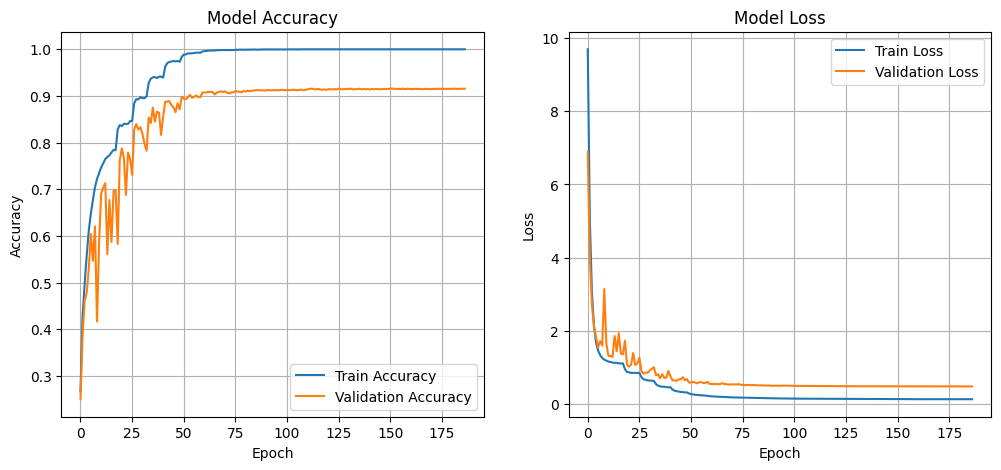

In [24]:
# Plot learning curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(RLOP_history.history['accuracy'], label='Train Accuracy')
plt.plot(RLOP_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(RLOP_history.history['loss'], label='Train Loss')
plt.plot(RLOP_history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


In [26]:
# Calculate the test loss and accuracy for CDR
test_loss_cdr, test_acc_cdr = CDR_model.evaluate(test_dataset, verbose=2)

# Print the test accuracy
print(test_acc_cdr)

79/79 - 1s - 11ms/step - accuracy: 0.8803 - loss: 0.7304
0.880299985408783


In [27]:
# Calculate the test loss and accuracy for CDR
test_loss_rlop, test_acc_rlop = RLOP_model.evaluate(test_dataset, verbose=2)

# Print the test accuracy
print(test_acc_rlop)

79/79 - 1s - 11ms/step - accuracy: 0.9149 - loss: 0.4832
0.914900004863739


In [25]:
# Download the files
from google.colab import files
files.download("/content/best_resnet_CDR.h5")
files.download("/content/best_resnet_RLOP.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>